In [1]:
import numpy as np
from src.monte_carlo import monte_carlo_mix, Scroll, Item

In [2]:
%load_ext autoreload
%autoreload 2

## 14g 手套

In [3]:
WEAPON_SCROLL_PRICE = {"A": 269, "B": 6.4, "C": 4800, "D": 9.5}
SHIELD_SCROLL_PRICE = {"A": 79, "B": 2000, "C": 1522, "D": 700}
WEAPON_SWORD = {"108": 25000, "107": 15000}

In [4]:
mxb_to_rmb = 56 # 56W mxb = 1rmb
GROVE_ATTACK_PRICE = {
    "10": 1500,
    "11": 2500,
    "12": 5000,
    "13": 14000,
    "14": 41000,
    "15": 2200*mxb_to_rmb,
    "16": 6000*mxb_to_rmb,
    "17": 12500*mxb_to_rmb
}

GROVE_SCROLL_PRICE = {
    "A": 33, 
    "B": 597, 
    "C": 14959, 
    "D": 2325
}
item_price = 2500

SCROLL_A = Scroll("A_10p_+3", success_p=0.11, atk_value=3, destroy_on_fail_p=0.0)
SCROLL_B = Scroll("B_60p_+2", success_p=0.66, atk_value=2, destroy_on_fail_p=0.0)
SCROLL_C = Scroll("C_30p_+3_boom50", success_p=0.33, atk_value=3, destroy_on_fail_p=0.50)
SCROLL_D = Scroll("D_70p_+2_boom50", success_p=0.77, atk_value=2, destroy_on_fail_p=0.50)

SCROLL_SET = {"A": SCROLL_A, "B": SCROLL_B, "C": SCROLL_C, "D": SCROLL_D}
NAME_TO_KEY = {SCROLL_A.name: "A", SCROLL_B.name: "B", SCROLL_C.name: "C", SCROLL_D.name: "D"}  # 便于反查类型键

In [5]:
import copy
from typing import Callable, List, Dict

Strategy = Callable[[Item], Scroll]
StopCondition = Callable[[Item], bool]

# ========== 策略工厂 ==========
def strategy_fixed_sequence(
    seq: List[str],
    SCROLL_SET: Dict[str, Scroll]
    ) -> Strategy:
    """
    固定序列：按照提供的卷轴名序列循环使用（长度不足时可循环或截断）。
    例如：["C", "C", "B", "B", "B", "B", "B"]
    """

    scrolls = [SCROLL_SET[name] for name in seq]

    def strat(state: Item) -> Scroll:
        if state.attempts_used < state.num_slots:
            idx = min(state.attempts_used, len(seq) - 1)
            return scrolls[idx]
        else:
            raise ValueError("No more slots to update")
    return strat

# ========== 目标工厂 ==========
def stop_all_success() -> StopCondition:
    # 目标：在不爆装情况下，全成功
    def cond(state: Item) -> bool:
        return (np.sum(state.results_history) == state.num_slots) and (not state.destroyed)
    return cond

def stop_atk_at_least(target_atk: int) -> StopCondition:
    # 目标：总攻击力达到阈值（不爆装）
    def cond(state: Item) -> bool:
        return (state.atk_value >= target_atk) and (not state.destroyed)
    return cond

# ========== 流程工厂 ==========
def simulate_until_one_satisfy(
    strategy: Strategy,
    stop_condition: StopCondition,
    stop_on_first_fail: bool = False, # 是否失败就不再砸卷
) -> list:

    def run_procedure(rng: np.random.Generator,
                    item_template: Item,
    ):
        all_items_list = []

        while True:

            item_state = copy.deepcopy(item_template)
            # 对每件装备的砸卷处理
            while item_state.attempts_used < item_state.num_slots:
                scroll = strategy(item_state)

                # 记录本次使用的卷轴
                item_state.history.append(scroll.name)

                # 消耗一次尝试
                item_state.attempts_used += 1

                # 判定
                if rng.random() < scroll.success_p:
                    item_state.atk_value += scroll.atk_value
                    item_state.power_value += scroll.power_value
                    item_state.ag_value += scroll.ag_value
                    item_state.int_value += scroll.int_value
                    item_state.lucky_value += scroll.lucky_value

                    item_state.results_history.append(True)
                else:
                    item_state.results_history.append(False)

                    # 判定该装备是否消失
                    if scroll.destroy_on_fail_p > 0 and (rng.random() < scroll.destroy_on_fail_p):
                        item_state.destroyed = True
                        break
                    
                    # 新策略：只要失败，就不再继续砸
                    if stop_on_first_fail:
                        break

            all_items_list.append(item_state)
            # 完成该装备的一轮砸卷后
            if stop_condition(item_state):
                return all_items_list
    
    return run_procedure

In [6]:
import time
seed = int(time.time())
print(f"seed: {seed}")
rng = np.random.default_rng(seed)
trials = 100000

target = stop_all_success()

scroll_list = ["D", "D", "D", "D", "D", "D", "D"]
strat1 = strategy_fixed_sequence(scroll_list, SCROLL_SET)

Procedure = simulate_until_one_satisfy(strat1, target, stop_on_first_fail=True)
item_state = Item("BrownGrove", num_slots=7)
results = monte_carlo_mix(rng, trials, item_state, Procedure, properties=["atk_value"])

grove_cost = np.mean(results['scrolls_distribution']['D_70p_+2_boom50']) * GROVE_SCROLL_PRICE["D"]
scrolls_cost = np.mean(results['items_distribution']) * item_price 

v,c = np.unique(results['items_properties']['atk_value']['good'], return_counts=True)
grove_sell = 0
for v_i,c_i in zip(v,c):
    if v_i < 14:
        if str(v_i) in GROVE_ATTACK_PRICE.keys():
            print(v_i, c_i)
            grove_sell += GROVE_ATTACK_PRICE[str(v_i)]*c_i
grove_sell /= trials

print(f"total cost: {(grove_cost+scrolls_cost-grove_sell):.2f}")
print(f"grove cost: {grove_cost:.2f}, scrolls_cost: {scrolls_cost:.2f}, grove_sell: {grove_sell:.2f}")

seed: 1758276800


Monte Carlo: 100%|██████████| 100000/100000 [00:12<00:00, 8023.66it/s]


10 19201
12 14918
total cost: 67311.99
grove cost: 52787.10, scrolls_cost: 15558.80, grove_sell: 1033.91


In [14]:
import matplotlib.pyplot as plt
from src.plot import create_figure

def plot_bar_int(data, ax=None):
    values, counts = np.unique(data, return_counts=True)
    idx = values == 0
    values = np.delete(values, idx)
    counts = np.delete(counts, idx)
    if ax is None:
        plt.bar(values, counts/len(data), width=0.9, align='center', edgecolor='k')
        plt.xticks(values)  # 每个整数一个刻度
    else:
        ax.bar(values, countslen(data), width=0.9, align='center', edgecolor='k')
        ax.set_xticks(values)  # 每个整数一个刻度

def plot_cdf_pdf(data, fig_title):

    num_items = []
    probability = []
    for i in range(0,np.max(data)+1):
        probability.append(np.sum(np.array(data) < i+1) / len(data))
        num_items.append(i+1)

    valid_num_items = range(0, int(np.mean(data) + 3*np.std(data, ddof=1)))
    valid_probability = np.array(probability)[valid_num_items]

    fig, axs = create_figure(1,3)
    fig.suptitle(fig_title)
    ax1 = fig.add_subplot(axs[0])
    ax1.plot(valid_probability)
    ax1.set_title("CDF")

    ax2 = fig.add_subplot(axs[1])
    ax2.hist(data, bins=np.arange(0,np.max(data),5))
    # ax2.axvline(np.max(valid_num_items), color='r')
    ax2.axvline(np.mean(data), color='r')
    ax2.set_title("PDF")
    ticks = ax2.get_yticks()
    ax2.set_yticks(ticks)  # 固定刻度位置，防止后续自动变化
    ax2.set_yticklabels([f"{t/len(data):g}" for t in ticks])

    ax3 = fig.add_subplot(axs[2])
    ax3.plot(np.diff(valid_probability))

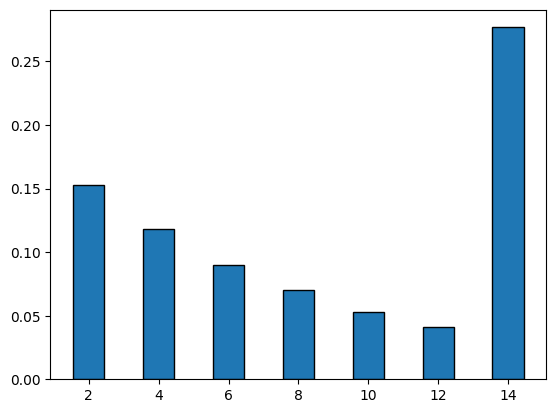

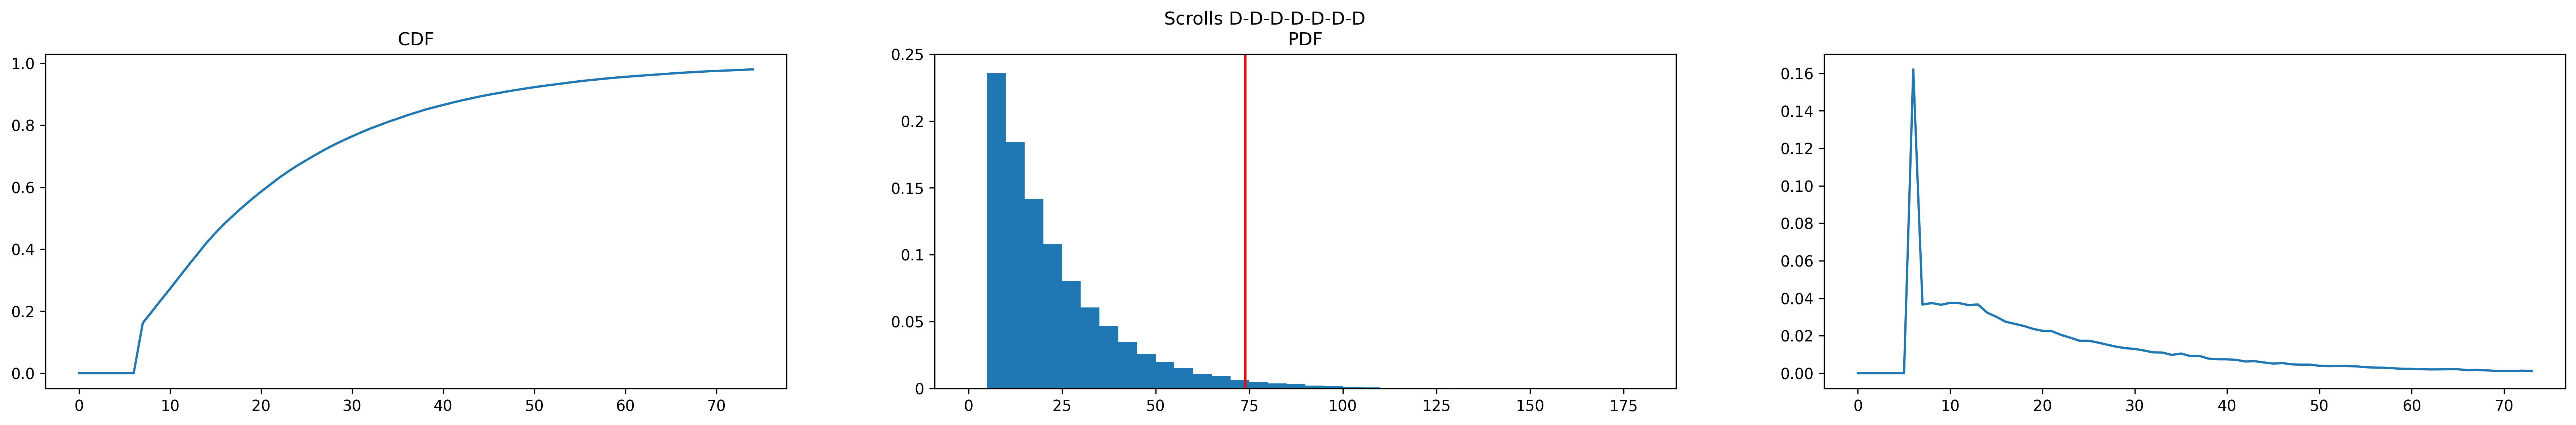

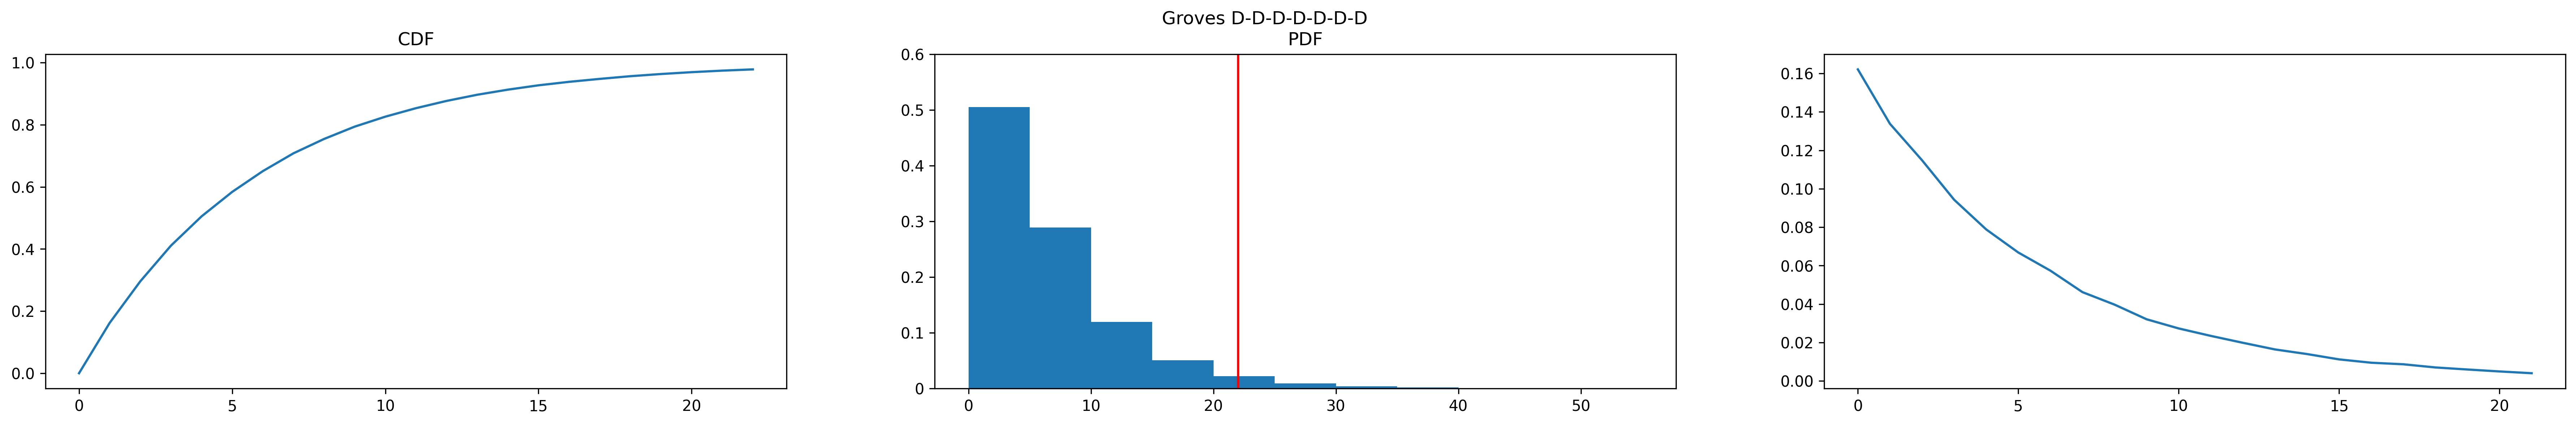

In [8]:
data = results['items_properties']['atk_value']['good']
plot_bar_int(data)

data = results['scrolls_distribution']['D_70p_+2_boom50']
plot_cdf_pdf(data, "Scrolls D-D-D-D-D-D-D")

plot_cdf_pdf(results['items_distribution'], "Groves D-D-D-D-D-D-D")

## 2 +3 14g

In [9]:
# ========== 流程工厂 ==========
def simulate_until_one_satisfy(
    strategy: Strategy,
    stop_condition: StopCondition,
    stop_on_first_fail: bool = False, # 是否失败就不再砸卷
) -> list:

    def run_procedure(rng: np.random.Generator,
                    item_template: Item,
    ):
        all_items_list = []

        while True:

            item_state = copy.deepcopy(item_template)
            # 对每件装备的砸卷处理
            while item_state.attempts_used < item_state.num_slots:
                scroll = strategy(item_state)

                # 记录本次使用的卷轴
                item_state.history.append(scroll.name)

                # 消耗一次尝试
                item_state.attempts_used += 1

                # 判定
                if rng.random() < scroll.success_p:
                    item_state.atk_value += scroll.atk_value
                    item_state.power_value += scroll.power_value
                    item_state.ag_value += scroll.ag_value
                    item_state.int_value += scroll.int_value
                    item_state.lucky_value += scroll.lucky_value

                    item_state.results_history.append(True)
                else:
                    item_state.results_history.append(False)

                    # 判定该装备是否消失
                    if scroll.destroy_on_fail_p > 0 and (rng.random() < scroll.destroy_on_fail_p):
                        item_state.destroyed = True
                        break
                    
                    # 第一次失败就不砸了
                    if item_state.attempts_used == 1:
                        break

                # 判定是否达到攻击力阈值
                if stop_condition(item_state):
                    break

            all_items_list.append(item_state)
            # 完成该装备的一轮砸卷后
            if stop_condition(item_state):
                return all_items_list
    
    return run_procedure

In [10]:
seed = int(time.time())
print(f"seed: {seed}")
rng = np.random.default_rng(seed)
trials = 100000

target = stop_atk_at_least(14)

scroll_list = ["A", "D", "D", "D", "D", "D", "C"]
strat1 = strategy_fixed_sequence(scroll_list, SCROLL_SET)

Procedure = simulate_until_one_satisfy(strat1, target, stop_on_first_fail=True)
item_state = Item("BrownGrove", num_slots=7)
results = monte_carlo_mix(rng, trials, item_state, Procedure, properties=["atk_value"])

seed: 1758276817


Monte Carlo: 100%|██████████| 100000/100000 [01:13<00:00, 1360.89it/s]


In [11]:
cost_small = np.mean(results['scrolls_distribution']['D_70p_+2_boom50']) * GROVE_SCROLL_PRICE["D"]
cost_big = np.mean(results['scrolls_distribution']['A_10p_+3']) * GROVE_SCROLL_PRICE["A"]
cost_big_big = np.mean(results['scrolls_distribution']['C_30p_+3_boom50']) * GROVE_SCROLL_PRICE["C"]
scrolls_cost = cost_small + cost_big
grove_cost = np.mean(results['items_distribution']) * item_price 

v,c = np.unique(results['items_properties']['atk_value']['good'], return_counts=True)
grove_sell = 0
for v_i,c_i in zip(v,c):
    if v_i < 14:
        if str(v_i) in GROVE_ATTACK_PRICE.keys():
            print(v_i, c_i)
            grove_sell += GROVE_ATTACK_PRICE[str(v_i)]*c_i
grove_sell /= trials

print(f"total cost: {(grove_cost+scrolls_cost-grove_sell):.2f}")
print(f"grove cost: {grove_cost:.2f}, scrolls_cost: {scrolls_cost:.2f}, grove_sell: {grove_sell:.2f}")

10 1976
11 43343
12 12782
13 58446
total cost: 197265.26
grove cost: 145929.35, scrolls_cost: 61270.66, grove_sell: 9934.75


In [12]:
v,c = np.unique(results['items_properties']['atk_value']['good'], return_counts=True)
print(f"14 attack {c[v==14]}")
print(f"16 attack {c[v==16]}")
print((c[v==16]*GROVE_ATTACK_PRICE['16']+c[v==14]*GROVE_ATTACK_PRICE['14'])/trials)

14 attack [43028]
16 attack [56972]
[209067.4]


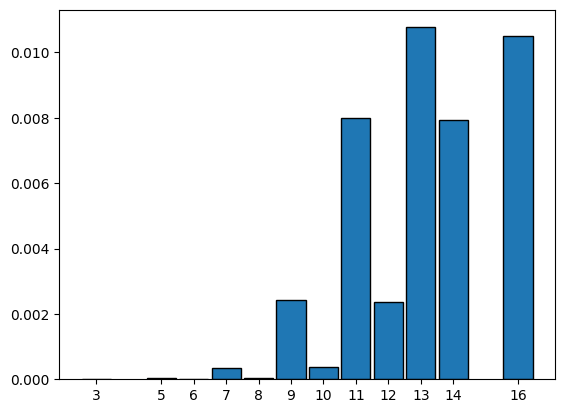

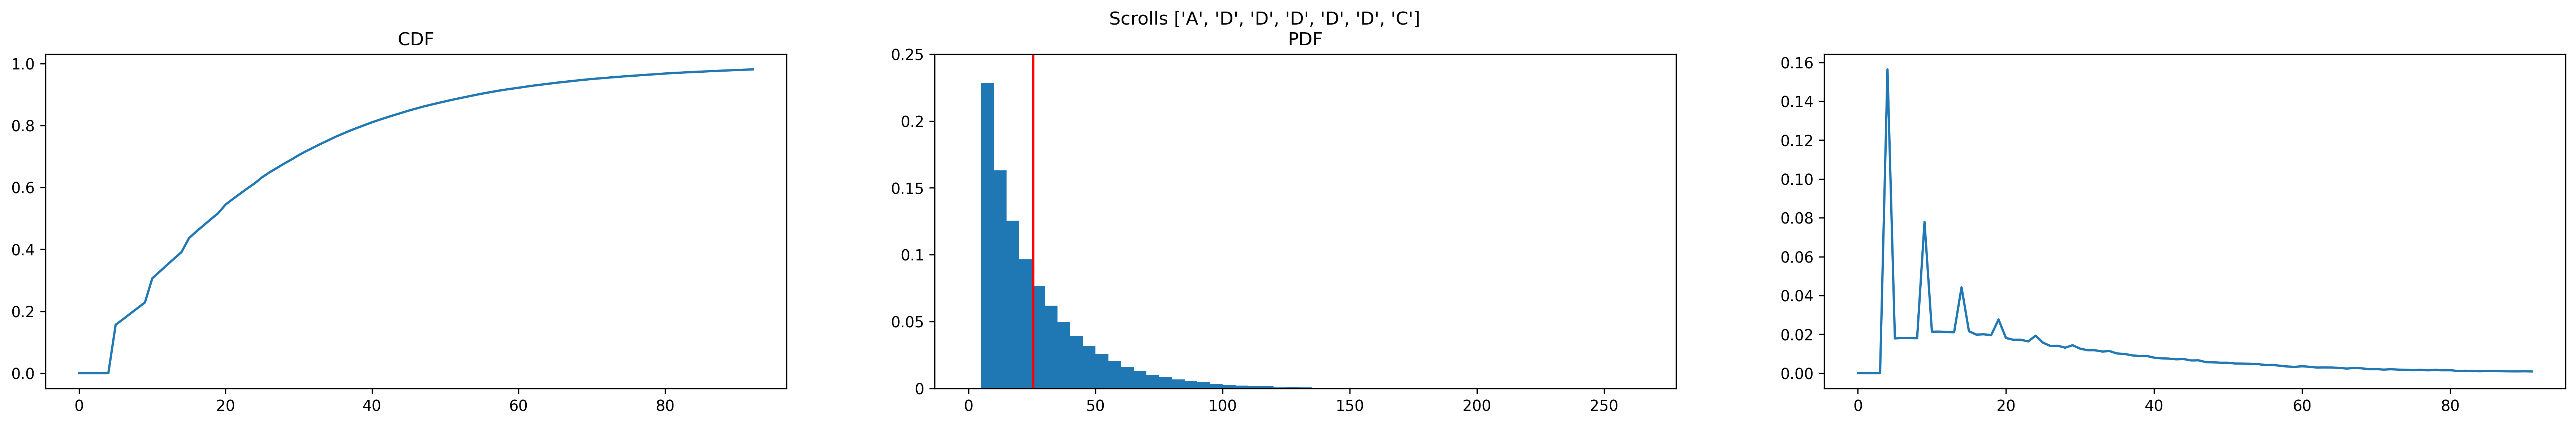

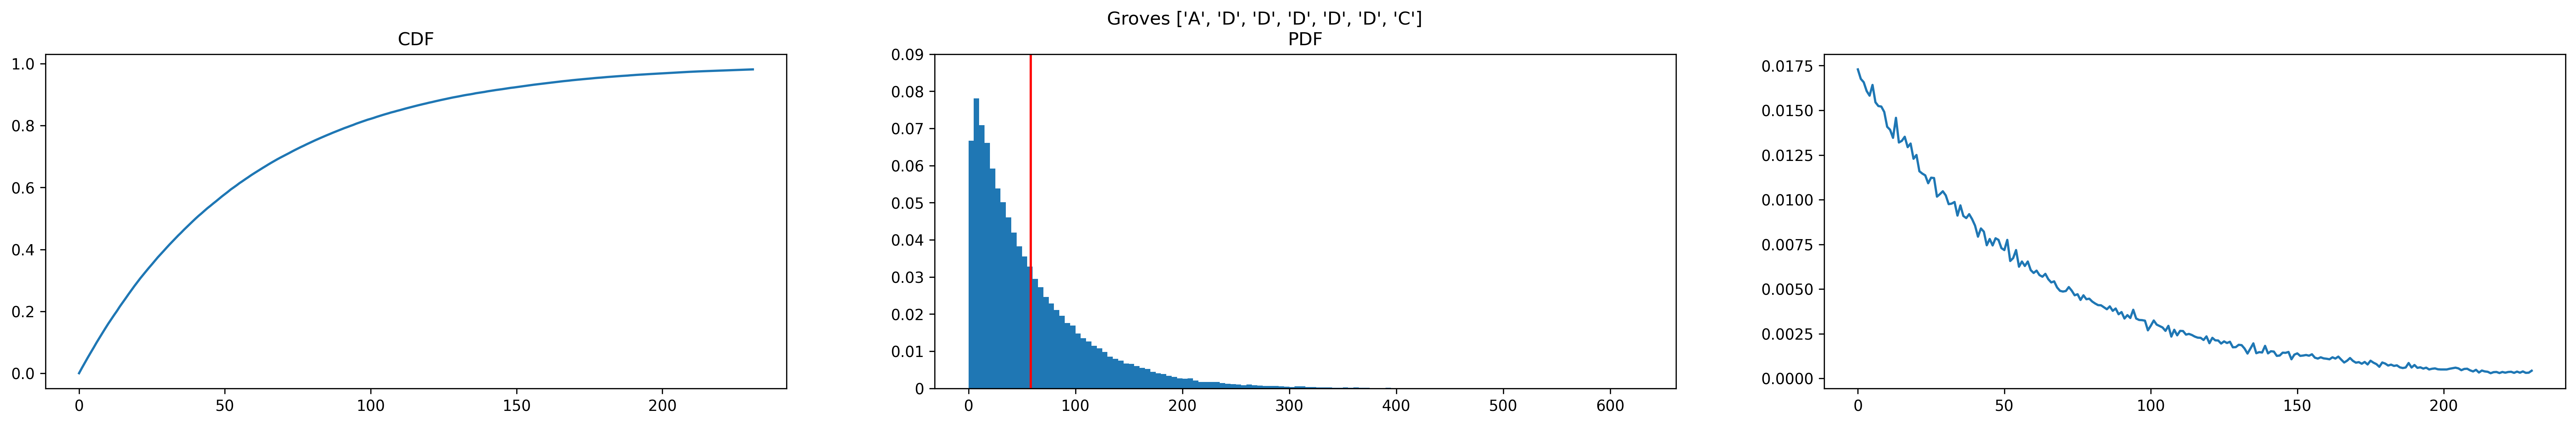

In [15]:
data = results['items_properties']['atk_value']['good']
plot_bar_int(data)

data = results['scrolls_distribution']['D_70p_+2_boom50']
plot_cdf_pdf(data, f"Scrolls {scroll_list}")

plot_cdf_pdf(results['items_distribution'], f"Groves {scroll_list}")